# Project CRM - Data Advanced Analytics Business Case

![Teste](https://www.inkjetwholesale.com.au/blog/wp-content/uploads/2017/10/buying-cycle.png)

Public Case:

iFood is the lead food delivery app in Brazil, present in over a thousand cities.
Keeping a high customer engagement is key for growing and consolidating the company’s
position as the market leader.

Data Analysts working within the data team are constantly challenged to provide insights and
value to the company through open scope projects. This case intends to simulate that.
In this case, you are presented a sample dataset, that mocks metainformation on the customer
and on iFood campaign interactions with that customer.

It is your challenge to understand the data, find business opportunities & insights and to propose
any data driven action to optimize the campaigns results & generate value to the company.
This case aims to evaluate your Data skills and knowledge for two possible roles:

- Data Analyst Business:
    - Perform robust exploratory analysis, rich with business insights & data driven proposals
to add value to the company and have strong communication skills to influence the
decision making
- Data Advanced Analytics
    - Perform robust exploratory analysis, using advanced analytics tools and statistical
methods to generate data products to optimize business results (predictive & clustering
models, for example)


### About the dataset
The data set contains socio-demographic and firmographic features about 2.240 customers who
were contacted. Additionally, it contains a flag for those customers who responded the campaign,
by buying the product

### Goals of the Project

- Explore the data - you need to provide the marketing team a better understanding of the characteristics features of respodents;
- At least 3 important insights;
- Model a customer segmentation that can increase the campaign profit;
- Create a predictive model to maximize the profit of the next marketing campaign;

### Deliverable
- Model that can be used by the business and marketing team.

### Data Source
https://github.com/ifood/ifood-data-business-analyst-test

### Solution Planning

Since the business case is composed by 3 parts, I will split the problem in 3 different notebooks to be well organized and structured. The goal of the data analysis notebook will be analyze the provided dataset and understand the data. Also,  it is necessary to create some hypothesis, validate it using exploratory data analysis and extract some actionable insights. The second part is using some methods to create cluster of clients according to the profile and use it to create some recommendations for the marketing campaign. It should increase the profit, since we are aiming specific clients. The last part will be the predictive model, joining the results generated by the clustering modelization, we can predict if the client will accept the next offer and then calculate the business impact based on the inputs of the dataset.

#### 1. Planning of Data Analysis [DONE]
- Business understanding and context
- Describe Data
- Hypothesis Creation
- Feature Engineering
- Filtering Variables
- Exploratory Data Analysis

#### 2. Planning of Clustering [DONE]
- Data Preparation
- Feature Selection
- Modeling Cluster
- Cluster Analysis
- Recommendations


#### 3. Planning of Predictive Model
- Data Preparation
- Feature Selection
- Machine Learning Modeling
- Hyper parameters Fine-Tunning
- Evaluation
- Business Impact


### Data Dictionary

![Data](images/metadata-table.PNG)

## Classification Model - Customer Propensity 

## 0.0 Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.class_weight import compute_class_weight

filterwarnings('ignore')
plt.style.use("ggplot")

### 0.1 Helper Functions

In [41]:
def descriptive_analysis(numerical_df):
    # Function that calculate all the statistics measures for the dataset
    # Central tendency - Mean, median
    ct1 = pd.DataFrame(numerical_df.apply(np.mean)).T
    ct2 = pd.DataFrame(numerical_df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(numerical_df.apply(np.std)).T
    d2 = pd.DataFrame(numerical_df.apply(min)).T
    d3 = pd.DataFrame(numerical_df.apply(max)).T
    d4 = pd.DataFrame(numerical_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(numerical_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(numerical_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
    m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

    return m

In [42]:
def evaluate_models(model_list, X, y, cv = 5, threshold = 0.5):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    results_df = pd.DataFrame([], columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Validation Accuracy', 'Validation Precision', 'Validation Recall'])

    for name, model in model_list:

        train_accuracy = []
        train_precision  = []
        train_recall  = []

        val_accuracy = []
        val_precision = []
        val_recall = []

        for train_index, val_index in skf.split(X, y):

            X_train_fold = X.iloc[train_index, :]
            X_val_fold = X.iloc[val_index, :]

            y_train_fold = y.iloc[train_index]
            y_val_fold = y.iloc[val_index]

            model_pipe = Pipeline([
                                ('preprocessor', preprocessor),
                                ('selector', SequentialFeatureSelector(DecisionTreeClassifier())),
                                ('model', model)
                            ])
            
            model_pipe.fit(X_train_fold, y_train_fold)

            # Predict on the training and testing sets
            y_train_pred = model_pipe.predict_proba(X_train_fold)
            y_train_pred = (y_train_pred[:,1] > threshold).astype(int)
            y_val_pred = model_pipe.predict_proba(X_val_fold)
            y_val_pred = (y_val_pred[:,1] > threshold).astype(int)

            # Calculate the evaluation metrics for the training set
            train_accuracy.append(accuracy_score(y_train_fold, y_train_pred))
            train_precision.append(precision_score(y_train_fold, y_train_pred))
            train_recall.append(recall_score(y_train_fold, y_train_pred))

            # Calculate the evaluation metrics for the validation set
            val_accuracy.append(accuracy_score(y_val_fold, y_val_pred))
            val_precision.append(precision_score(y_val_fold, y_val_pred))
            val_recall.append(recall_score(y_val_fold, y_val_pred))

        model_metrics = [name, np.mean(train_accuracy), np.mean(train_precision), np.mean(train_recall), np.mean(val_accuracy), np.mean(val_precision), np.mean(val_recall)]

        results_df = results_df.append(pd.DataFrame([model_metrics], columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Validation Accuracy', 'Validation Precision', 'Validation Recall']), ignore_index=True)
        
    return results_df

In [43]:
def evaluate(y_true, y_pred_prob, threshold = 0.5):
    # convert probabilities to binary predictions
    y_pred = (y_pred_prob > threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC-AUC:", roc_auc)
    


### 1.0 Loading Data

In [44]:
df0 = pd.read_csv('../data/ml_project1_data.csv')

### 1.1 Rename Columns

In [45]:
old_columns = ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
               'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
               'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
               'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
               'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
               'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

lower_case = lambda x: x.lower()

new_columns = list(map(lower_case, old_columns))

df0.columns = new_columns

In [46]:
df0.head()

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,...,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


### 2.0 Missing Values

In [47]:
(df0.isna().sum() / len(df0))*100

id                     0.000000
year_birth             0.000000
education              0.000000
marital_status         0.000000
income                 1.071429
kidhome                0.000000
teenhome               0.000000
dt_customer            0.000000
recency                0.000000
mntwines               0.000000
mntfruits              0.000000
mntmeatproducts        0.000000
mntfishproducts        0.000000
mntsweetproducts       0.000000
mntgoldprods           0.000000
numdealspurchases      0.000000
numwebpurchases        0.000000
numcatalogpurchases    0.000000
numstorepurchases      0.000000
numwebvisitsmonth      0.000000
acceptedcmp3           0.000000
acceptedcmp4           0.000000
acceptedcmp5           0.000000
acceptedcmp1           0.000000
acceptedcmp2           0.000000
complain               0.000000
z_costcontact          0.000000
z_revenue              0.000000
response               0.000000
dtype: float64

Income has around 1% with NaN values. We need to replace this in the future.

### 2.1 Data Types

In [48]:
df0.dtypes

id                       int64
year_birth               int64
education               object
marital_status          object
income                 float64
kidhome                  int64
teenhome                 int64
dt_customer             object
recency                  int64
mntwines                 int64
mntfruits                int64
mntmeatproducts          int64
mntfishproducts          int64
mntsweetproducts         int64
mntgoldprods             int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
z_costcontact            int64
z_revenue                int64
response                 int64
dtype: object

In [49]:
df0['dt_customer'] = pd.to_datetime(df0['dt_customer'])

Only dt_customer was wrong, then we changed it to datetime even if we are not using now.

All the others statistics and exploratory analysis are in the crm_ifood_data_analysis.ipynb.

### 2.2 Checking Outliers 

Detecting and handling outliers is a critical step in any data analysis process. Outliers refer to data points that differ significantly from the rest of the dataset and can result from measurement errors, data collection errors, or recording issues. Outliers can have a severe impact on the reliability and accuracy of statistical analyses, leading to misleading or even invalid results. 

One effective approach to identifying outliers is to use a box plot, which provides a clear visual representation of the distribution of the data. Once identified, it's essential to handle outliers appropriately, which could involve correcting or removing them from the dataset. By taking these necessary steps, we can ensure the validity and reliability of our statistical analyses.

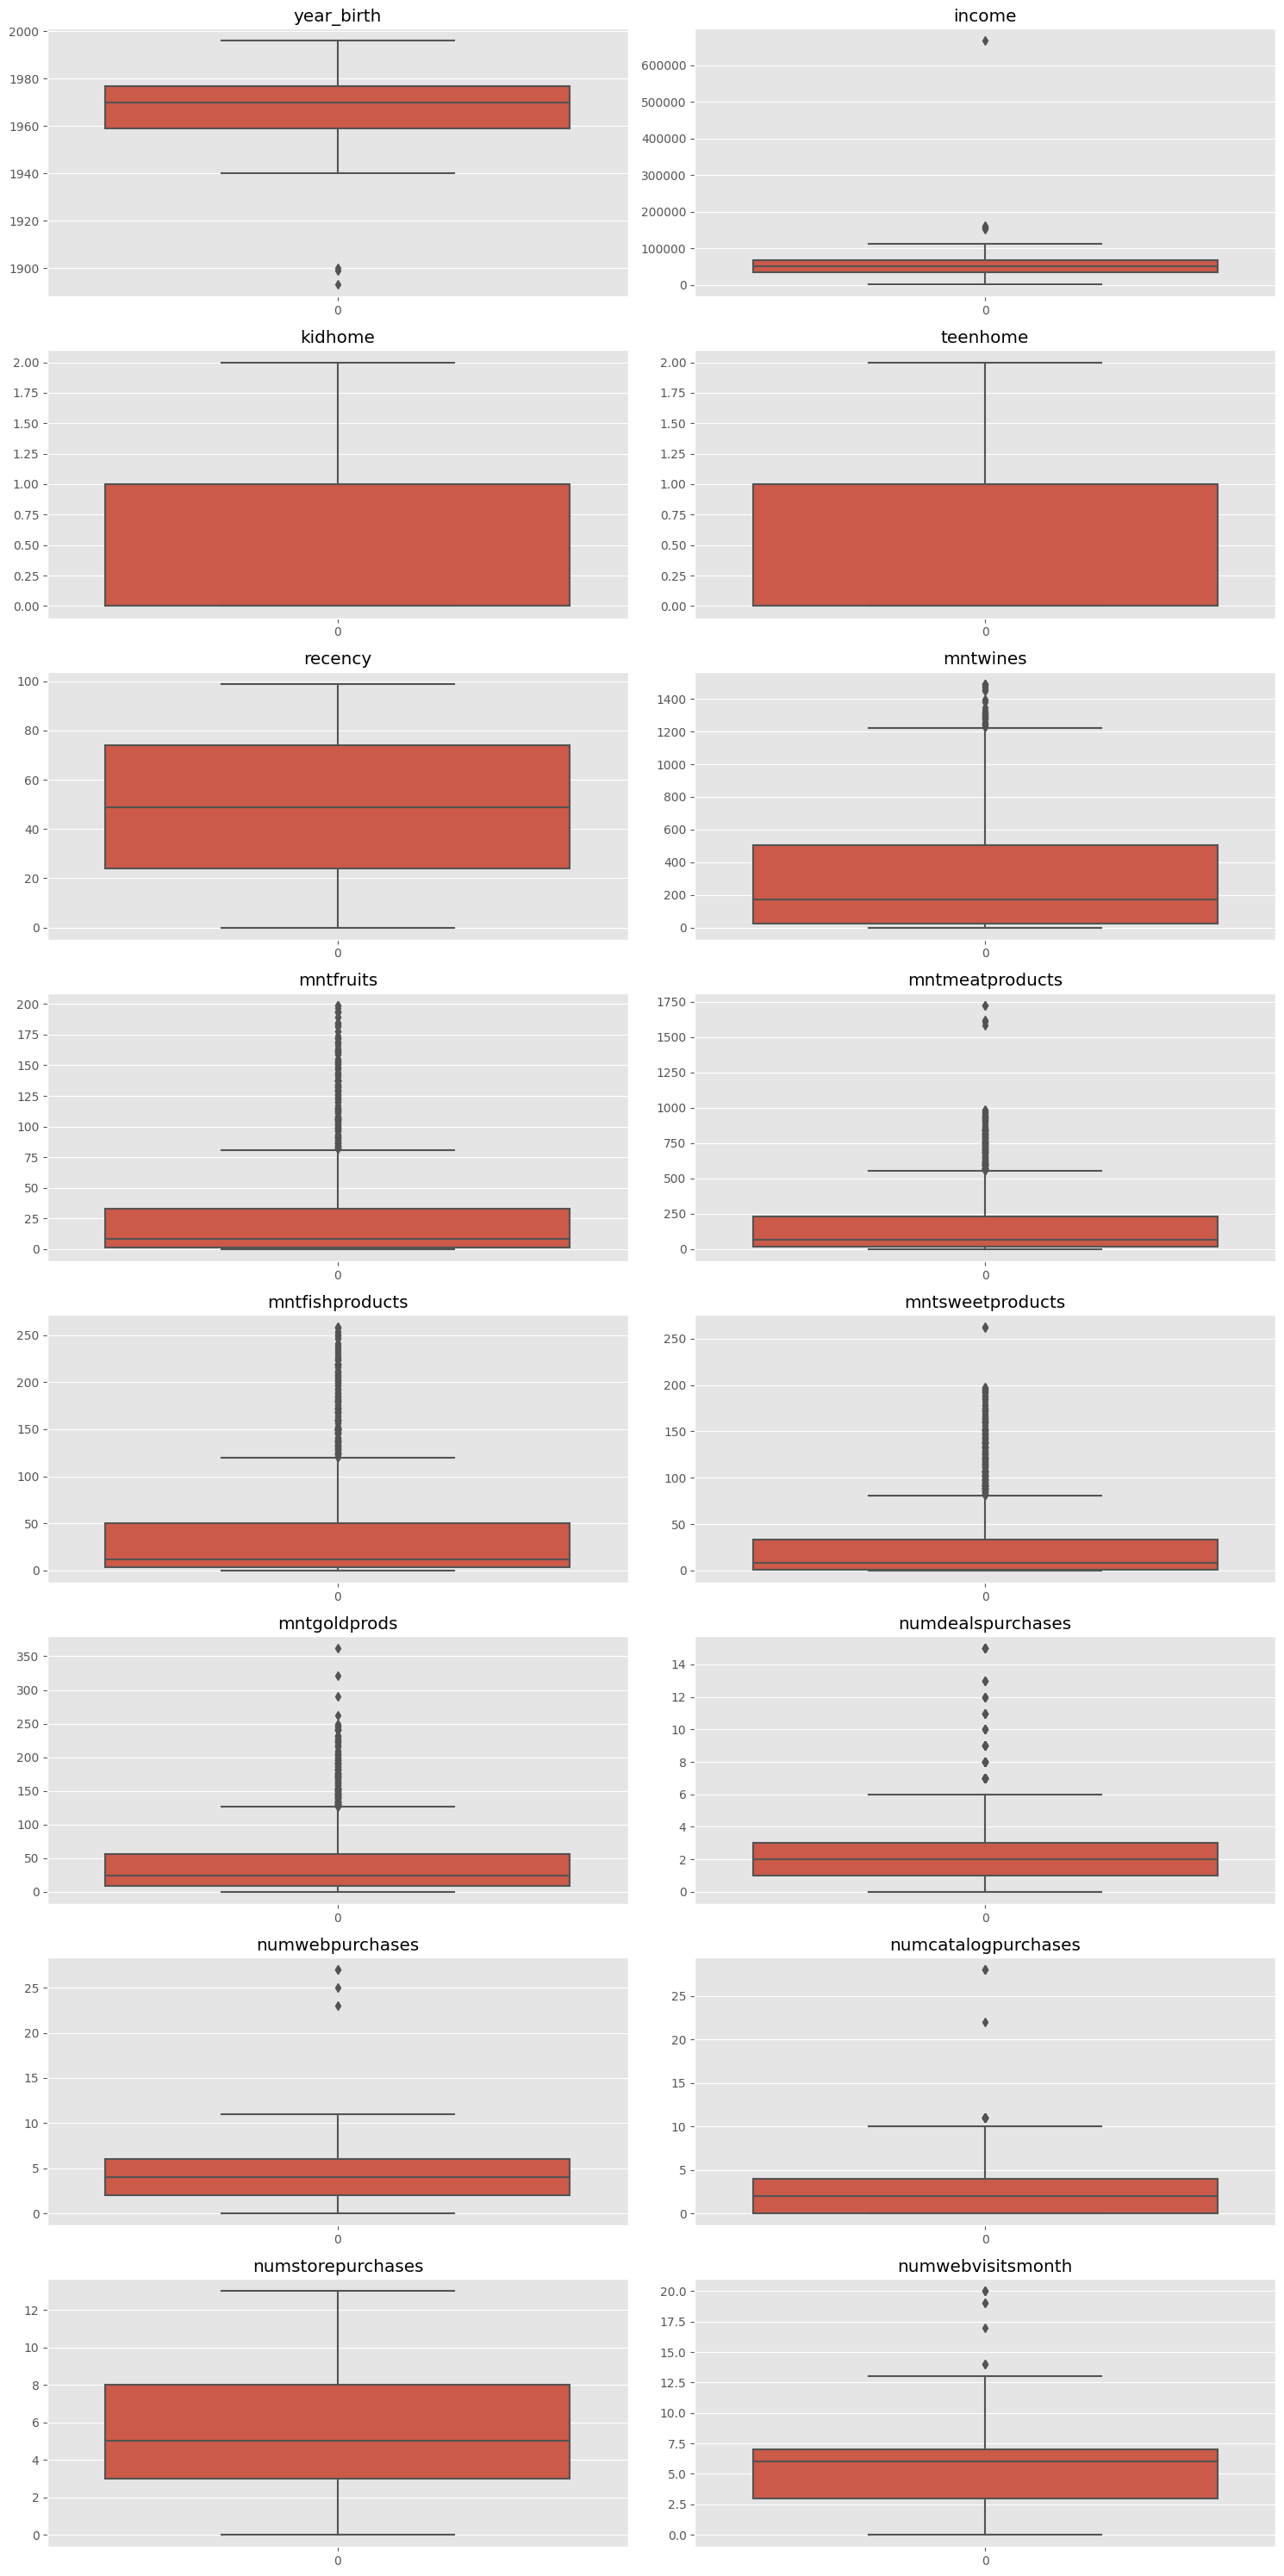

In [50]:
cols_to_check = ['year_birth','income','kidhome','teenhome','recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

plt.figure(1, figsize = (15,30))
for i,col in enumerate(cols_to_check):
    plt.subplot(8, 2, i+1)
    sns.boxplot(df0[col])
    plt.title(col)
    plt.tight_layout()
    

It's possible to see that that numstorepurchases, recency, kidhome and teenhome there are no outliers. The other columns must be treated if used in by any algorithm sensible to outliers.

### 2.3 Descriptive Statistics

In [51]:
num_vars = df0.select_dtypes(include = ['int64', 'float64'])
cat_vars = df0.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

#### Numerical Attributes

In [52]:
stat = descriptive_analysis(num_vars)
stat

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,id,5592.159821,5458.5,3245.937415,0.0,11191.0,11191.0,0.039832,-1.190028
1,year_birth,1968.805804,1970.0,11.981394,1893.0,1996.0,103.0,-0.349944,0.717464
2,income,52247.251354,NaN,25167.396174,1730.0,666666.0,664936.0,6.763487,159.636700
3,kidhome,0.444196,0.0,0.538278,0.0,2.0,2.0,0.635288,-0.779661
4,teenhome,0.506250,0.0,0.544417,0.0,2.0,2.0,0.407115,-0.986235
5,recency,49.109375,49.0,28.955987,0.0,99.0,99.0,-0.001987,-1.201897
6,mntwines,303.935714,173.5,336.522251,0.0,1493.0,1493.0,1.175771,0.598744
7,mntfruits,26.302232,8.0,39.764555,0.0,199.0,199.0,2.102063,4.050976
8,mntmeatproducts,166.950000,67.0,225.664984,0.0,1725.0,1725.0,2.083233,5.516724
9,mntfishproducts,37.525446,12.0,54.616784,0.0,259.0,259.0,1.919769,3.096461


- year_birth shows some insconsistency, since the minimum year is 1893, which leads to an age of more then 100 years. Also, the average age is about 44 years (assuming the dataset is from 2014).
- income of $1730 (yearly) is unrealistic for a family, maybe this is a inconsistency or students that lives alone but receive from parents. 
- kidhome and teenhome is limited to 2 childrens.
- The number of days since the last purchase (recency) is about 49 days, on average.
- The mean amount spent with wines and meat is greater than the other products (more expensive).
- People use to buy, on average, almost the same frequency on web or at the store.
- The sucess rate of the past campaigns (from 1 to 5) is about 7% except for the second one, which is 1.3%.
- The complain rate is less than 1%.
- z_costcontact and z_revenue does not have any information.
- The sucess rate of the last campaign (7th or response) is about 15%.

#### Categorical Attributes

In [53]:
cat_vars['education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [54]:
cat_vars['marital_status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [55]:
cat_vars['marital_status'].value_counts(normalize=True)*100

Married     38.571429
Together    25.892857
Single      21.428571
Divorced    10.357143
Widow        3.437500
Alone        0.133929
Absurd       0.089286
YOLO         0.089286
Name: marital_status, dtype: float64

Education and Marital Status has low cardinality, so it is possible to treat them as dummies or encodings. However, there are some weird categories in martital status, such as: Alone, Absurd and YOLO. In this case, we can drop them for the dataset or we can transform these 3 categories in "Other". In this case, we pick the last choice.

In [56]:
df0['marital_status'] = df0.apply(lambda x: 'Other' if (x['marital_status'] == 'Absurd' or x['marital_status'] == 'YOLO') else x['marital_status'], axis = 1)

### 2.4 Balance Response

In [57]:
df0['response'].value_counts(normalize = True)*100

0    85.089286
1    14.910714
Name: response, dtype: float64

### 3.0 Feature Engineering 

In machine learning, feature engineering is a crucial step in improving the accuracy and effectiveness of a predictive model. The process involves creating new variables by transforming or combining existing variables in the dataset. Feature engineering is necessary to capture new insights or relationships between variables that may not be evident from the original data. By applying domain knowledge and exploring the data, we can identify features that are relevant to the problem at hand and improve the predictive performance of the model. Therefore, it is essential to carefully consider the feature engineering process before building a machine learning model.

In [58]:
df1 = df0.copy()

In [59]:
# Creating the loyalty variable - days
df1['loyalty_days'] = df1['dt_customer'].max() - df1['dt_customer']
df1['loyalty_days'] = df1['loyalty_days'] //  np.timedelta64(1, 'D')

# Creating the loyalty variable - convert to month
df1['loyalty_months'] = df1['loyalty_days'] / 30

In [60]:
# Creating the total amount spent by each customer - MONETARY
df1['amount_spent'] = df1['mntmeatproducts'] + df1['mntwines'] + df1['mntfruits'] + df1['mntsweetproducts'] + df1['mntfishproducts']
# Creating the amount spent per month 
df1['amount_spent_month'] = df1.apply(lambda x:  x['amount_spent'] / x['loyalty_months'] if x['loyalty_months'] > 1 else x['amount_spent'], axis = 1)

In [61]:
# Creating the total number of purchases - FREQUENCY
df1['total_purchases'] = df1['numdealspurchases'] + df1['numwebpurchases'] + df1['numcatalogpurchases'] + df1['numstorepurchases']

In [62]:
df1['accepted_campaigns'] = df1['acceptedcmp1'] + df1['acceptedcmp2'] + df1['acceptedcmp3'] + df1['acceptedcmp4'] + df1['acceptedcmp5']

It is necessary to pay attention to the variable accepted_campaigns. If we add the campaign 6, it will have data leakeage!!!

In [63]:
# Create the age of the customer
df1['age'] = df1['dt_customer'].dt.year.max() - df1['year_birth']

In [64]:
# Creating the total number of purchasese by each month
df1['purchases_month'] = df1['total_purchases'] / (df1['loyalty_months'] + 1)

In [65]:
# Creating percentage spent on different products
df1['percentage_spent_wines'] = df1['mntwines'] / df1['amount_spent']
df1['percentage_spent_fruits'] = df1['mntfruits'] / df1['amount_spent']
df1['percentage_spent_meat'] = df1['mntmeatproducts'] / df1['amount_spent']
df1['percentage_spent_fish'] = df1['mntfishproducts'] / df1['amount_spent']
df1['percentage_spent_sweet'] = df1['mntsweetproducts'] / df1['amount_spent']
df1['percentage_spent_gold'] = df1['mntgoldprods'] / df1['amount_spent']

In [66]:
# Creating percentage purchases on different channel types
df1['percentage_type_deals'] = df1['numdealspurchases'] / df1['total_purchases']
df1['percentage_type_web'] = df1['numwebpurchases'] / df1['total_purchases']
df1['percentage_type_catalog'] = df1['numcatalogpurchases'] / df1['total_purchases']
df1['percentage_type_store'] = df1['numstorepurchases'] / df1['total_purchases']

### 4.0 Pre-processing

Pre-processing features is a crucial step in preparing data for analysis and modeling. It involves handling missing values, scaling, normalization, encoding categorical variables, and other data transformations. These transformations ensure that the data is in a format suitable for machine learning algorithms to process and can significantly enhance the accuracy of the model.

To streamline this process, it's essential to create a pipeline of transformations that automates the pre-processing process by chaining multiple transformation steps into a single pipeline. This pipeline helps to pre-process the data consistently and efficiently, ensuring that the same set of transformations is applied to new data in a standardized manner. By using a pipeline, we can simplify the pre-processing stage and enable faster iteration and experimentation with various models.

In [67]:
df2 = df1.copy()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('response', axis = 1), df2['response'], test_size = 0.15)

Since the dataset is not big as I want, I'm using the approach with train/validation (cross-validation) and a final test. Then, for the last one I used only 15% of the whole dataset.

In [69]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_train.shape)

X_train: (1904, 46)
X_test: (336, 46)
y_train: (1904,)
y_test: (1904,)


To decide which scaler and encoding to use, we need to check the distribution of our data (data analysis notebook), in order to modify or not the data structure. Since most of them are not following a normal distribution, we choose MinMax Scaler. It is important to remark here  that this is important only for algorithms that uses distance and optimization, which is not the case of trees for example.

In [70]:
# Features to use imputer and scaler
numeric_features = ['income','recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 
                     'mntsweetproducts', 'mntgoldprods', 'numdealspurchases',
                     'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases',
                     'numwebvisitsmonth', 'loyalty_days', 'loyalty_months',
                     'amount_spent', 'amount_spent_month', 'total_purchases',
                     'age', 'purchases_month','mntfishproducts',
                     'percentage_spent_wines', 'percentage_spent_fruits',
                     'percentage_spent_meat', 'percentage_spent_fish',
                     'percentage_spent_sweet', 'percentage_spent_gold',
                     'percentage_type_deals', 'percentage_type_web',
                     'percentage_type_catalog', 'percentage_type_store']

# Features to conver to ordinal encoding
categorical_features = ['kidhome', 'teenhome', 'education', 'marital_status']

# Response variable
target = 'response'

# Numerical transformations
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", MinMaxScaler())]
)

# Categorical transformations
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
]
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features, ),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
    
)



### 5.0 Feature Selection

Selecting the right set of features is a crucial step in improving the accuracy and performance of machine learning models. Feature selection involves identifying the most relevant and informative variables from the dataset and including them in the model.

By selecting the most important features, we can improve the predictive power of the model and reduce the processing time. There are several algorithms for feature selection, including filter methods (Chi test, correlation), wrapper methods (RFE, backward/forward selection), and embedded methods (Random Forests, Lasso).

In this case, we test the variables through variance analysis to eliminate low-variance features, followed by a backward selection approach to determine the most informative variables. By utilizing these techniques, we can ensure that the model is optimized for performance and accuracy, resulting in better predictions and improved decision-making capabilities.

In [71]:
X_train.var().reset_index().rename(columns = {0: 'var'}).sort_values('var').head(5)

,index,var
24,z_revenue,0.000000
23,z_costcontact,0.000000
34,percentage_spent_fruits,0.005438
37,percentage_spent_sweet,0.006476
22,complain,0.008854


In [72]:
X_train = X_train.drop(['id', 'year_birth', 'z_revenue', 'z_costcontact', 'dt_customer'], axis = 1)
X_test = X_test.drop(['id', 'year_birth', 'z_revenue', 'z_costcontact', 'dt_customer'], axis = 1)

It is possible to see that z_revenue and z_costcontact are two variables without variation, then, we can eliminate preliminarly. ID and year birth don't contain any useful information as well.

In [73]:
feat_selector_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SequentialFeatureSelector(DecisionTreeClassifier()))
])


feat_selector_pipe.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['income', 'recency',
                                                   'mntwines', 'mntfruits',
                                                   'mntmeatproducts',
                                                   'mntsweetproducts',
                                                   'mntgoldprods',
                                                   'numdealspurchases',
                                                   'numwebpurchases',
                                                   'numcatalogpurchases',
                                                   'numstorepu...
                                                   'percentage_spent_gold',
                                                   'percentage_type_deals',
                                                   'percentage_type_web',
                                                   'percentage_type_catalog',
                                                   'percentage_type_store']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['kidhome', 'teenhome',
                                                   'education',
                                                   'marital_status'])])),
                ('selector',
                 SequentialFeatureSelector(estimator=DecisionTreeClassifier()))])

In [74]:
selected_features = feat_selector_pipe.get_feature_names_out()
selected_features

array(['num__income', 'num__recency', 'num__numdealspurchases',
       'num__numstorepurchases', 'num__numwebvisitsmonth',
       'num__amount_spent_month', 'num__total_purchases',
       'num__percentage_spent_wines', 'num__percentage_type_deals',
       'cat__kidhome', 'cat__teenhome', 'cat__education',
       'cat__marital_status', 'remainder__acceptedcmp3',
       'remainder__acceptedcmp4', 'remainder__acceptedcmp5',
       'remainder__acceptedcmp1', 'remainder__acceptedcmp2',
       'remainder__complain', 'remainder__accepted_campaigns'],
      dtype=object)

In [75]:
len(selected_features)

20

### 6.0 Modeling

There are several algorithms available to perform this task, each with its own strengths and weaknesses. In this case, I will test four popular algorithms - Logistic Regression, SVM, Decision Tree, and XGBoost - and evaluate their performance using cross-validation.

To optimize the selected algorithm's performance, techniques such as Grid Search will be used to fine-tune the parameters. Finally, the model's performance will be evaluated using metrics such as accuracy, precision, and recall on both the training and test sets to avoid overfitting.

Overall, this approach will enable us to create a robust classifier capable of accurately predicting customer behavior, helping businesses make informed decisions and achieve their marketing goals.

#### Baseline

The baseline model is a reference point for evaluating the performance of more complex models and can be an essential step in building effective marketing campaign strategies. For this case, we are assuming a random strategy for the previous marketing campaign, just respecting the average conversion rate.

In [76]:
evaluate_models([('Baseline', DummyClassifier(strategy='stratified'))], X_train, y_train)

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,Baseline,0.756433,0.166374,0.166997,0.741057,0.132883,0.140909


In [77]:
# Random model based on the acceptance rate of last campaign
dummy_model = DummyClassifier(strategy='stratified')

# Fit the dummy classifier to the training data
dummy_model.fit(X_train, y_train)

# Make predictions on the training data
y_baseline_train = dummy_model.predict(X_train)

# Make predictions on the test data
y_baseline_test = dummy_model.predict(X_test)


In [78]:
evaluate(y_train, y_baseline_train)

Accuracy: 0.7715336134453782
Precision: 0.20955882352941177
Recall: 0.20577617328519857
F1-score: 0.20765027322404372
ROC-AUC: 0.536815560520903


In [79]:
evaluate(y_test, y_baseline_test)

Accuracy: 0.7470238095238095
Precision: 0.22
Recall: 0.19298245614035087
F1-score: 0.205607476635514
ROC-AUC: 0.5265987549518958


In [80]:
results_df = evaluate_models([('LogisticRegression', LogisticRegression()), ('SVM', SVC(probability = True)), ('DecisionTree', DecisionTreeClassifier()), ('XGBoost', XGBClassifier())], X_train, y_train)
results_df

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,LogisticRegression,0.885767,0.718332,0.351107,0.888136,0.735883,0.357597
1,SVM,0.884586,0.772848,0.289650,0.876053,0.706391,0.263701
2,DecisionTree,0.993960,1.000000,0.958485,0.837715,0.451976,0.443961
3,XGBoost,0.994616,0.988147,0.974730,0.883398,0.638909,0.447338


To ensure fair evaluation of our models, I am using Stratified k-fold cross-validation, which guarantees that each fold of the data contains roughly the same proportion of each class as the entire dataset. This technique helps to prevent the model from being unfairly evaluated, and ensures that the performance metrics are not overly influenced by the class with more instances.

Since the problem is imbalanced, accuracy should not be used as the sole metric to evaluate the models. Instead, I am considering precision and recall as the primary metrics.

- Precision measures the accuracy of the model in predicting positive instances, i.e., the proportion of predicted positives that are actually positive.
- Recall, on the other hand, measures the proportion of true positive predictions out of all actual positive instances in the data. It is a valuable metric in this context, as it tells us how well the model is able to identify the positive instances, which is particularly important in marketing campaigns where we want to accurately identify potential customers.

In the first trial, our model is overfitting a lot, which can be very bad for the evaluation on new data. Decision trees and XGBoost have a parameter that can balance the class of our dataset, let's try to evaluate both with this parameter.

In [93]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))



In [91]:
class_weight_dict

{0: 0.5851259987707437, 1: 3.436823104693141}

In [96]:
results_df = evaluate_models([('DecisionTree', DecisionTreeClassifier(class_weight=class_weight_dict)), ('XGBoost', XGBClassifier(scale_pos_weight =class_weight_dict[1]))], X_train, y_train)
results_df

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,DecisionTree,0.994616,0.964347,1.0,0.840865,0.459439,0.458571
1,XGBoost,0.994616,0.964347,1.0,0.880782,0.600598,0.545455


XGBoost seems to achieve a better evaluation than Decision Tree, then let's try to improve it by using a cross-entropy loss, which is a loss that can penalize more when the model is wrong.

In [97]:
results_df = evaluate_models([('XGBoost', XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', scale_pos_weight =class_weight_dict[1]))], X_train, y_train)
results_df

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,XGBoost,0.994485,0.963497,1.0,0.869755,0.574646,0.418896


The cross-entropy loss doesn't show a improvement. Let's try to play with the threshold.

#### Threshold Variation

In [98]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

thr_res = pd.DataFrame()
for thr in thresholds:
    res = evaluate_models([('XGBoost-' + str(thr), XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', scale_pos_weight  = class_weight_dict[1]))], X_train, y_train, cv = 3, threshold=thr)
    thr_res = pd.concat([thr_res, res])

thr_res

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,XGBoost-0.2,0.995273,0.968629,1.000000,0.866596,0.534998,0.642590
0,XGBoost-0.3,0.995273,0.968629,1.000000,0.859769,0.517916,0.570516
0,XGBoost-0.4,0.995273,0.968629,1.000000,0.857137,0.515295,0.480248
0,XGBoost-0.5,0.995273,0.968629,1.000000,0.868703,0.564786,0.418848
0,XGBoost-0.6,0.995273,0.968629,1.000000,0.876575,0.612275,0.426134
0,XGBoost-0.7,0.995273,0.968629,1.000000,0.877104,0.619009,0.407784
0,XGBoost-0.8,0.995273,0.998168,0.969281,0.878676,0.656872,0.357410


While increasing the threshold can improve precision, it's important to find the right balance between precision and recall to achieve the best overall performance. Grid Search can help us find the optimal threshold and other hyperparameters of the model by systematically testing different combinations of values. By doing so, we can fine-tune our model to achieve the highest possible performance on our dataset.

#### Optimization

To optimize our model, we are using the GridSearch method. This approach is a popular technique for hyperparameter optimization, which involves exhaustively searching a predefined set of hyperparameters and their possible values to find the optimal set of hyperparameters for a machine learning model.

In this particular case, we want to optimize the recall metric. This is because the cost of losing a customer purchase is higher than the cost of acquiring a new customer. Therefore, we want to make sure that our model is able to correctly identify as many potential customer churn cases as possible, even if that means sacrificing some precision. The GridSearch method will help us find the optimal hyperparameters that maximize our model's recall performance on our dataset.

In [100]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 10],
    'n_estimators': [200, 500],
    'objective' : ['binary:logistic'],
    'scale_pos_weight' : [class_weight_dict[1]]
}

model = XGBClassifier()

# Grid Search for hyperparameters tuning
grid_search = GridSearchCV( model, 
							param_grid,
							n_jobs = -1,
							cv = skf,
							scoring = 'recall',
							verbose = 3,
							refit = True)

# Pipeline de dados
xgb_pipe = Pipeline( steps = [('preprocessor', preprocessor),
							('selector', SequentialFeatureSelector(DecisionTreeClassifier())),
							('gridsearch', grid_search)])

# Fit treino
xgb_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['income', 'recency',
                                                   'mntwines', 'mntfruits',
                                                   'mntmeatproducts',
                                                   'mntsweetproducts',
                                                   'mntgoldprods',
                                                   'numdealspurchases',
                                                   'numwebpurchases',
                                                   'numcatalogpurchases',
                                                   'numstorepu...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.01, 0.1, 0.3],
                                          'max_depth': [3, 5, 10],
                                          'n_estimators': [200, 500],
                                          'objective': ['binary:logistic'],
                                          'scale_pos_weight': [3.436823104693141]},
                              scoring='recall', verbose=3))])

In [101]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1.056756,0.074998,0.009071,0.001642,0.01,3,500,binary:logistic,3.436823,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.607143,0.589286,0.600000,0.654545,0.690909,0.628377,0.038417,1
3,1.869303,0.083460,0.008301,0.000821,0.01,5,500,binary:logistic,3.436823,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.571429,0.589286,0.581818,0.563636,0.654545,0.592143,0.032405,2
6,0.391627,0.023150,0.005373,0.000997,0.1,3,200,binary:logistic,3.436823,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.553571,0.517857,0.654545,0.636364,0.581818,0.588831,0.050808,3
2,0.754931,0.089670,0.005415,0.001413,0.01,5,200,binary:logistic,3.436823,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.553571,0.642857,0.545455,0.545455,0.636364,0.584740,0.044946,4
0,0.399823,0.013873,0.005575,0.000858,0.01,3,200,binary:logistic,3.436823,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.553571,0.500000,0.581818,0.581818,0.618182,0.567078,0.039314,5
12,0.387396,0.013943,0.004617,0.000468,0.3,3,200,binary:logistic,3.436823,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",0.571429,0.482143,0.618182,0.618182,0.545455,0.567078,0.050840,5
7,1.097327,0.064812,0.008980,0.002753,0.1,3,500,binary:logistic,3.436823,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.535714,0.482143,0.600000,0.618182,0.545455,0.556299,0.048538,7
13,0.982766,0.044969,0.006545,0.000879,0.3,3,500,binary:logistic,3.436823,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",0.571429,0.464286,0.545455,0.618182,0.509091,0.541688,0.052543,8
8,0.703829,0.036838,0.006766,0.002033,0.1,5,200,binary:logistic,3.436823,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.517857,0.428571,0.563636,0.618182,0.563636,0.538377,0.063440,9
9,1.754804,0.037647,0.009630,0.002375,0.1,5,500,binary:logistic,3.436823,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.517857,0.428571,0.581818,0.600000,0.490909,0.523831,0.062222,10


#### Evaluation on the test set

In [102]:

# Predict on the training and testing sets
y_test_pred = xgb_pipe.predict_proba(X_test)

In [116]:
print('Metrics for the test:')
evaluate(y_test, y_test_pred[:, 1], threshold = 0.4)

Metrics for the test:
Accuracy: 0.7916666666666666
Precision: 0.42857142857142855
Recall: 0.6842105263157895
F1-score: 0.527027027027027
ROC-AUC: 0.8368861221153242


<AxesSubplot: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

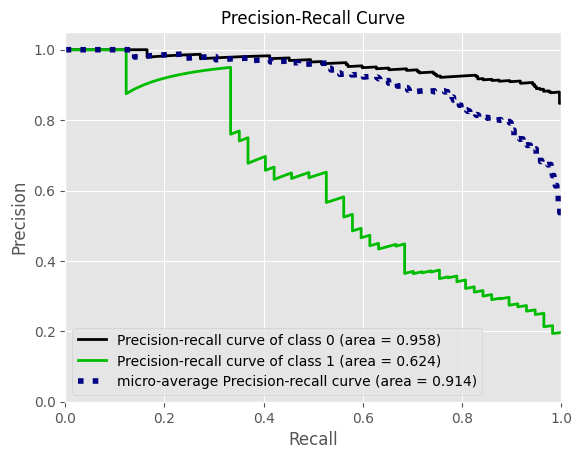

In [104]:
skplt.metrics.plot_precision_recall(y_test, y_test_pred)

In the precision-recall graphic it is possible to see the trade-off between both metrics. If we want to optimize more the model to the recall, the precision will decrease!

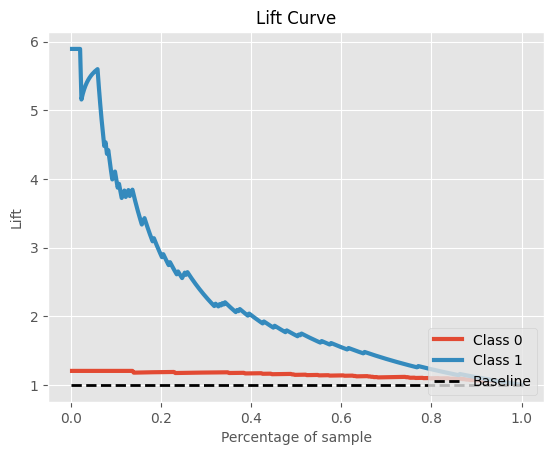

In [105]:
skplt.metrics.plot_lift_curve(y_test, y_test_pred)
plt.show()

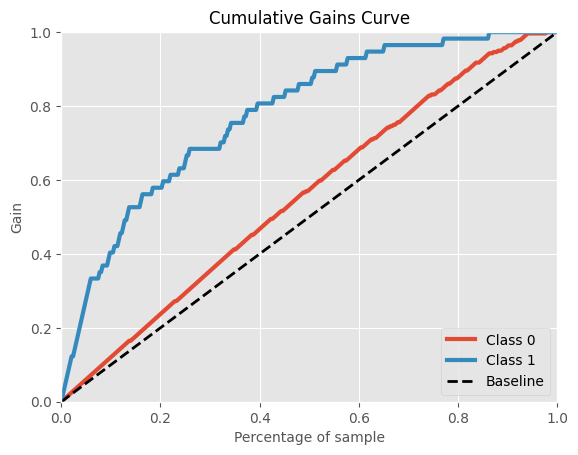

In [106]:
skplt.metrics.plot_cumulative_gain(y_test, y_test_pred)
plt.show()

Here's an improved version of the text:

The lift curve is a powerful tool for evaluating the performance of a classification model, particularly in marketing applications. By visualizing the relationship between the predicted probability of a positive response and the actual response rate, the lift curve can help identify segments of the population that are more likely to respond to a particular offer or campaign.

In this case, we can see that by targeting the top 20% of customers as identified by our model, our approach is 3.5 times more effective than random targeting. However, to gain a more complete understanding of the model's performance, we can also use a cumulative gains curve. This chart shows the cumulative response rate as more individuals are targeted, allowing us to identify the point at which the majority of responders have been captured.

Using the cumulative gains curve, we can see that if we target around 60% of the database, we can capture nearly all of the individuals who are likely to respond to our campaign. By translating these insights into business value, we can make informed decisions about the size of the population to target, ultimately saving money and improving the effectiveness of our marketing efforts.

To improve even more the metrics of the classification model, it may be necessary to get more data and new features that can help the model to distinguish between the class 1 and 0. Also, there are more 1 approache that can work: balancing the dataset with synthetic techniques such as SMOTE or other similar.

For this project, I will not explore the technique mentioned before.

### 7.0 Business Value

Since the customer cost is lower than the cost of lost a customer purchase, we want to maximize our recall. Then, we need to put our threshold very low to achieve the optimal point related to the business value.

In [120]:
y_pred_prob = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred_model = [int(p > 0.4) for p in y_pred_prob]

In [121]:
y_pred_baseline = y_baseline_test

In [122]:
comparison_test = pd.DataFrame({'y_true': y_test, 'y_pred_model': y_pred_model})
comparison_test['y_baseline'] = y_pred_baseline

comparison_test

,y_true,y_pred_model,y_baseline
998,0,1,1
75,0,0,0
2154,0,0,0
1606,0,0,0
963,0,0,0
...,...,...,...
1375,0,1,0
1739,0,0,0
1892,0,0,1
732,0,0,0


In [123]:
comparison_test = pd.concat([X_test['amount_spent_month'], comparison_test], axis = 1)
comparison_test

,amount_spent_month,y_true,y_pred_model,y_baseline
998,81.750000,0,1,1
75,0.646320,0,0,0
2154,1.961853,0,0,0
1606,63.119093,0,0,0
963,17.093023,0,0,0
...,...,...,...,...
1375,17.979094,0,1,0
1739,5.850000,0,0,0
1892,3.880309,0,0,1
732,39.031414,0,0,0


Offering a discount of Y% can be a powerful incentive when considering a customer for a marketing campaign that will run for the next X months. By providing a discount, you show the customer that you value their business and are willing to invest in a long-term relationship.

For instance, let's say we're running a marketing campaign for a specific product that is valid for 6 months, and the offer is _"Earn a voucher with a 30% discount on a specific product during 6 months!"_ In this scenario, we need to use the model's predictions to estimate the potential revenue and losses we may incur during the campaign period. Specifically, we need to consider:

- Customers that the model predicted would accept the campaign and purchased the product with the discount, generating revenue;
- Customers that the model did not predict correctly, who we invested in but didn't end up purchasing, leading to lost marketing costs;
- Customers that the model predicted would accept the campaign, but they did not make a purchase with the discount, resulting in lost revenue.

After calculating the costs and revenue, we can determine the expected return of the campaign. This will help us understand the effectiveness of the marketing campaign and inform future marketing decisions.





In [164]:
n_months = 6
discount = 0.3
cost_per_customer = 20

In [165]:
# Baseline Results
true_customer_detect_amount_baseline = (comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_baseline'] == 1)]['amount_spent_month'].values*(1-discount)*n_months).sum()
false_customer_detect_amount_baseline = comparison_test[(comparison_test['y_true'] == 0) & (comparison_test['y_baseline'] == 1)]['y_true'].count() * cost_per_customer
lost_amount_baseline = (comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_baseline'] == 0)]['amount_spent_month'].values*(1-discount)*n_months).sum()


print(f"The expected total amount of money earned for the next marketing campaign using the baseline model is: ${round(true_customer_detect_amount_baseline, 2)}")
print(f"The expected total amount of money lost due to the model not predicting a person who would accept the next marketing campaign using the baseline model is: ${round(lost_amount_baseline, 2)}")
print(f"The expected total amount of money lost due to the model predict a person who would no accept the next marketing campaign using the baseline model is: ${round(false_customer_detect_amount_baseline, 2)}")

print(f"Total expected return for the baseline model is: $ {round(true_customer_detect_amount_baseline - false_customer_detect_amount_baseline)}")


The expected total amount of money earned for the next marketing campaign using the baseline model is: $6717.45
The expected total amount of money lost due to the model not predicting a person who would accept the next marketing campaign using the baseline model is: $11877.24
The expected total amount of money lost due to the model predict a person who would no accept the next marketing campaign using the baseline model is: $780
Total expected return for the baseline model is: $ 5937


In [166]:

# Model Results
true_customer_detect_amount_model = (comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_pred_model'] == 1)]['amount_spent_month'].values*(1-discount)*n_months).sum()
false_customer_detect_amount_model = comparison_test[(comparison_test['y_true'] == 0) & (comparison_test['y_pred_model'] == 1)]['y_true'].count() * cost_per_customer
lost_amount_model = (comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_pred_model'] == 0)]['amount_spent_month'].values*(1-discount)*n_months).sum()

print(f"The expected total amount of money earned for the next marketing campaign using the ML model is: ${round(true_customer_detect_amount_model, 2)}")
print(f"The expected total amount of money lost due to the model not predicting a person who would accept the next marketing campaign using the ML model is: ${round(lost_amount_model, 2)}")
print(f"The expected total amount of money lost due to the model predict a person who would no accept the next marketing campaign using the ML model is: ${round(false_customer_detect_amount_model, 2)}")

print(f"Total expected return for the ML model is: $ {round(true_customer_detect_amount_model - false_customer_detect_amount_model)}")



The expected total amount of money earned for the next marketing campaign using the ML model is: $16447.76
The expected total amount of money lost due to the model not predicting a person who would accept the next marketing campaign using the ML model is: $2146.94
The expected total amount of money lost due to the model predict a person who would no accept the next marketing campaign using the ML model is: $1040
Total expected return for the ML model is: $ 15408


The comparison between the baseline model and the machine learning model for the next marketing campaign reveals a agreed with our lift curve, reaching 3x the improvement in expected returns using the ML model. The expected total amount of money earned for the next marketing campaign using the ML model is much higher than the baseline model. Additionally, the ML model also performs better in predicting customers who would accept the marketing campaign, resulting in lower expected total amount of money lost due to not predicting such customers. Overall, the ML model demonstrates superior performance compared to the baseline model, increasing revenue and significantly reducing the loss of potential customers.